In [24]:
import tensorflow
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [25]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [26]:
# there are 60,000 samples in the training dataset

X_train.shape

(60000, 28, 28)

In [27]:
# there are 10,000 samples in the testing dataset

X_test.shape

(10000, 28, 28)

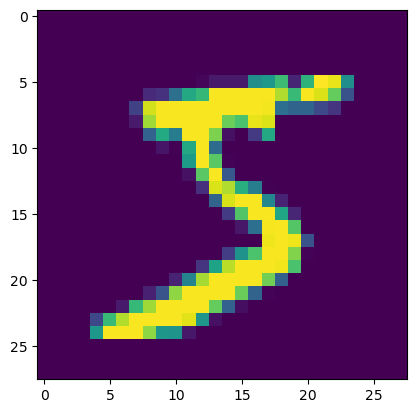

In [28]:
# To visualize a single image

plt.imshow(X_train[0])

In [29]:
# We can verify the correcting labels is 5 or not?

y_train[0]

5

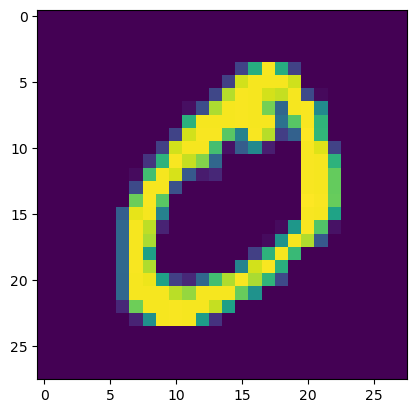

In [30]:
# We will consider a particular digit's images only for training to be faster
# We can also see Generator peformance on one set of images quickly.

X_train_zeros = X_train[y_train==0]
plt.imshow(X_train_zeros[0])

In [38]:
X_train_zeros.shape

(5923, 28, 28)

In [31]:
# Similary we will do the same for y_train (Zeros only)

y_train_zeros = y_train[y_train==0]
y_train_zeros

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

## Building a Discriminator layer

In [32]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape

In [33]:
dicriminator = Sequential()
dicriminator.add(Flatten(input_shape=[28,28]))
dicriminator.add(Dense(150, activation='relu'))
dicriminator.add(Dense(100, activation='relu'))
dicriminator.add(Dense(1, activation='sigmoid'))

dicriminator.compile(loss='binary_crossentropy', optimizer='adam')

## Building a Generator layer

In [34]:
generator = Sequential()
generator.add(Dense(100, activation='relu', input_shape=[100]))
generator.add(Dense(150, activation='relu'))
generator.add(Dense(784, activation='relu'))
generator.add(Dense(784, activation='relu'))

generator.add(Reshape([28,28]))

## Combining both models to form GAN

In [35]:
GAN = Sequential([generator, dicriminator])

In [36]:
dicriminator.trainable = False # dicriminator will not train in 2nd phase

In [37]:
GAN.compile(loss='binary_crossentropy', optimizer='adam')

## Training GAN on Training Batch

In [39]:
batch_size = 32

In [40]:
my_train_data = X_train_zeros

In [52]:
my_train_data.shape

(5923, 28, 28)

In [53]:
5923/32

185.09375

In [ ]:
# Creating the dataset using tensorflow ==> data ==> Dataset module

dataset =  tensorflow.data.Dataset.from_tensor_slices(my_train_data).shuffle(buffer_size=1000)

In [55]:
# type of the dataset generated

type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [56]:
# Setting up batches for generated dataset
# It will create 185 batches and drop the remainder

dataset = dataset.batch(batch_size=batch_size, drop_remainder=True).prefetch(1)

In [58]:
dataset

# We can see that every elements/ batches is of size (32, 28, 28)

<PrefetchDataset element_spec=TensorSpec(shape=(32, 28, 28), dtype=tf.uint8, name=None)>

#### Training the Generator and Discriminator

In [59]:
generator, discrimintor = GAN.layers

generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_11 (Dense)            (None, 150)               15150     
                                                                 
 dense_12 (Dense)            (None, 784)               118384    
                                                                 
 dense_13 (Dense)            (None, 784)               615440    
                                                                 
 reshape_1 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 759,074
Trainable params: 759,074
Non-trainable params: 0
_________________________________________________________________


In [60]:
discrimintor.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 150)               117750    
                                                                 
 dense_8 (Dense)             (None, 100)               15100     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 132,951
Trainable params: 0
Non-trainable params: 132,951
_________________________________________________________________


In [66]:
epochs = 1
tensorflow.random.set_seed(42)

codings_size = 100

for epoch in range(epochs):
    print(f"Currently on epoch {epoch}")
    
    for X_batch in dataset:
        # We have to create some noise and then concatenate with real image dataset before feeding to discriminator
        # Training of Discriminator will be phase 1 of GAN
        
        noise = tensorflow.random.normal(shape=[batch_size, codings_size])
        
        # passing the noise through generator to generate False/Fake image 
        gen_image = generator(noise)
        
        #Concatenate the Fake and real images
        X_real_fake_images = tensorflow.concat([gen_image, 
                                                tensorflow.dtypes.cast(X_batch, tensorflow.float32)], axis=0)
        
        # We need to generate the traget labels to the X_real_fake_images
        # First 32 images will fake and last 32 will be real.
        # we map real to 1's and fake to 0's
        
        y1 = tensorflow.constant([[0.]]*batch_size + [[1.]]*batch_size)
        
        # Now feed this Combination of real and Fake Images to Discriminator
        # We need to set the discriminator trainable to True in phase 1 and False during pahse 2
        discrimintor.trainable = True
        discrimintor.train_on_batch(X_real_fake_images, y1)
        
        # Now we have to train the generator
        # We need to create noise for generator
        # we need to also set the trainable of discriminator to False
        noise =  tensorflow.random.normal(shape=[batch_size, codings_size])
        y2 = tensorflow.constant([[1.0]]*batch_size)
        discrimintor.trainable = False
        
        # We will be training the GAN model instead of Generator layer
        GAN.train_on_batch(noise, y2)

Currently on epoch 0


In [70]:
#generating a random noise

noise = tensorflow.random.normal(shape=[10, codings_size])

In [71]:
#shape of generated noise

noise.shape

TensorShape([10, 100])

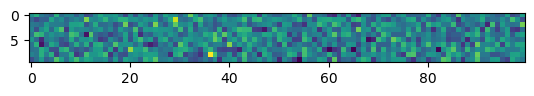

In [72]:
# Visualising the noise

plt.imshow(noise)

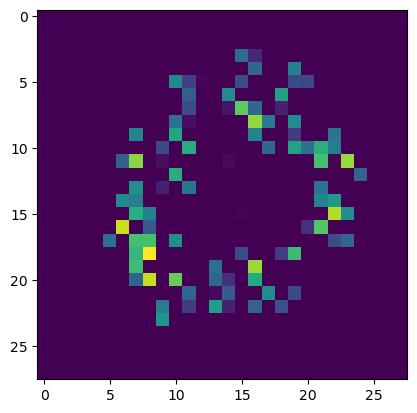

In [74]:
# Feeding noise to the generator and then visualising it

image = generator(noise)
plt.imshow(image[0])

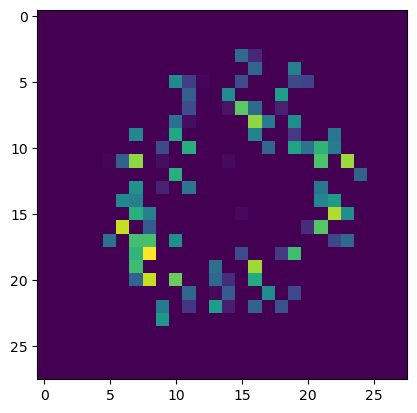

In [75]:
plt.imshow(image[3])